
# Proyecto Clasificador de vinos premium

Este cuaderno acompaña la entrega final del proyecto. Se documenta con mayor detalle el flujo completo: motivación, preparación de datos, desarrollo del modelo y evaluación visual de resultados.



## Introducción
- **Problema:** clasificar si un vino será considerado *premium* (calidad ≥ 7 en el dataset Wine Quality de UCI) o permanecerá en la categoría estándar.
- **Relevancia:** muchas bodegas solo necesitan saber si un lote alcanzará la etiqueta "reserva" o "alta calidad" para decidir procesos extra de maduración o precio.
- **Metodología:** se combinan los datos reales de vino tinto y blanco y se entrena una red híbrida con capas `Conv1D` + `Bidirectional LSTM` + rama densa paralela. El pipeline se implementa en `wine_quality.py` y aquí se ilustra paso a paso.



## Datos y exploración rápida
1. Se leen los archivos originales (`winequality-red.csv` y `winequality-white.csv`) y se agrega la columna `wine_type` para distinguirlos.
2. Se elimina cualquier duplicado y se inspecciona la distribución original de la variable `quality`.
3. Se describe estadísticamente cada característica para entender magnitudes y dispersión.


In [31]:

%matplotlib inline
import os
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import tensorflow as tf

PROJECT_ROOT = Path.cwd()
os.environ.setdefault('MPLCONFIGDIR', str(PROJECT_ROOT / '.matplotlib_cache'))
(PROJECT_ROOT / '.matplotlib_cache').mkdir(exist_ok=True)

if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

from wine_quality import (
    load_dataset,
    prepare_data,
    build_model,
    DEFAULT_THRESHOLD,
)

sns.set_theme(style='whitegrid')
np.random.seed(42)
tf.random.set_seed(42)

df = load_dataset()
print(f"Registros combinados: {len(df)} | Columnas: {df.shape[1]}")
df.head()


Registros combinados: 5320 | Columnas: 13


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,wine_type
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,0
4,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.9978,3.51,0.56,9.4,5,0


In [32]:

df.describe().T[['mean', 'std', 'min', 'max']]


,mean,std,min,max
fixed acidity,7.215179,1.319671,3.80000,15.90000
volatile acidity,0.344130,0.168248,0.08000,1.58000
citric acid,0.318494,0.147157,0.00000,1.66000
residual sugar,5.048477,4.500180,0.60000,65.80000
chlorides,0.056690,0.036863,0.00900,0.61100
free sulfur dioxide,30.036654,17.805045,1.00000,289.00000
total sulfur dioxide,114.109023,56.774223,6.00000,440.00000
density,0.994535,0.002966,0.98711,1.03898
pH,3.224664,0.160379,2.72000,4.01000
sulphates,0.533357,0.149743,0.22000,2.00000


/var/folders/p0/p33m29vs00bgdlh5jzqrt1380000gn/T/ipykernel_78966/2410402657.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='quality', data=df, palette='viridis')


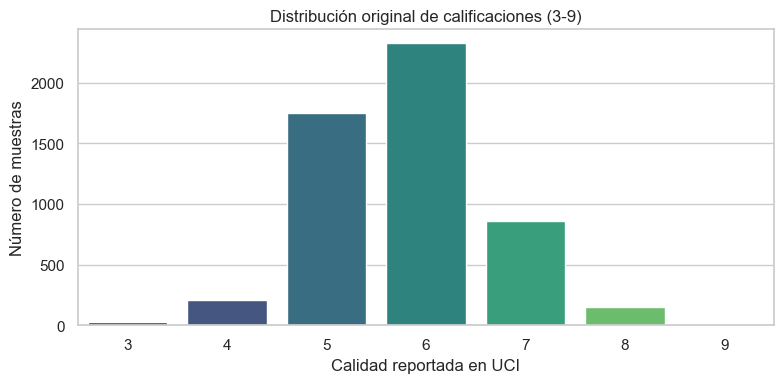

In [33]:

plt.figure(figsize=(8,4))
sns.countplot(x='quality', data=df, palette='viridis')
plt.title('Distribución original de calificaciones (3-9)')
plt.xlabel('Calidad reportada en UCI')
plt.ylabel('Número de muestras')
plt.tight_layout()
plt.show()



## Preparación y arquitectura
- Se convierte la variable `quality` en una etiqueta binaria (`target = 1` si calidad ≥7).
- Se separan conjuntos `train/val/test` estratificados y se aplica `StandardScaler`.
- La clase positiva es minoritaria, por lo que se asigna un peso > 2.5 durante el entrenamiento.
- Arquitectura: normalización inicial → rama densa + rama secuencial (Conv1D + BiLSTM) → concatenación → capa densa final sigmoidal.


In [34]:

(
    X_train,
    X_val,
    X_test,
    y_train,
    y_val,
    y_test,
    scaler,
    class_weights,
    feature_order,
) = prepare_data(df)

print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")
print(f"Proporción de etiqueta premium en train: {y_train.mean():.3f}")
class_weights


Train: (3404, 12), Val: (852, 12), Test: (1064, 12)
Proporción de etiqueta premium en train: 0.189


{0: 1.0, 1: 4.2775193798449616}

In [35]:

model = build_model(X_train.shape[1])
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=18, restore_best_weights=True, monitor='val_accuracy'),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.35, patience=8, monitor='val_loss'),
]
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=200,
    batch_size=128,
    class_weight=class_weights,
    callbacks=callbacks,
    verbose=2,
)


Epoch 1/200
27/27 - 2s - 64ms/step - accuracy: 0.6563 - loss: 0.9656 - val_accuracy: 0.7606 - val_loss: 0.5194 - learning_rate: 7.0000e-04
Epoch 2/200
27/27 - 0s - 8ms/step - accuracy: 0.7350 - loss: 0.8475 - val_accuracy: 0.7477 - val_loss: 0.5152 - learning_rate: 7.0000e-04
Epoch 3/200
27/27 - 0s - 8ms/step - accuracy: 0.7382 - loss: 0.8261 - val_accuracy: 0.7453 - val_loss: 0.5156 - learning_rate: 7.0000e-04
Epoch 4/200
27/27 - 0s - 9ms/step - accuracy: 0.7380 - loss: 0.8047 - val_accuracy: 0.7406 - val_loss: 0.5131 - learning_rate: 7.0000e-04
Epoch 5/200
27/27 - 0s - 11ms/step - accuracy: 0.7468 - loss: 0.7871 - val_accuracy: 0.7383 - val_loss: 0.5194 - learning_rate: 7.0000e-04
Epoch 6/200
27/27 - 0s - 11ms/step - accuracy: 0.7418 - loss: 0.7832 - val_accuracy: 0.7300 - val_loss: 0.5217 - learning_rate: 7.0000e-04
Epoch 7/200
27/27 - 0s - 11ms/step - accuracy: 0.7435 - loss: 0.7726 - val_accuracy: 0.7160 - val_loss: 0.5334 - learning_rate: 7.0000e-04
Epoch 8/200
27/27 - 0s - 11ms/


## Resultados numéricos y visuales
Se evalúa sobre el conjunto de prueba, utilizando un umbral de 0.45 para catalogar como premium. Además del reporte clásico, se agregan:
- **Matriz de confusión:** ayuda a ver la tasa de falsos positivos/negativos.
- **Curva ROC + AUC:** indica la capacidad discriminante del modelo entre ambos grupos.


In [36]:

probs = model.predict(X_test, verbose=0).flatten()
preds = (probs >= DEFAULT_THRESHOLD).astype(int)
report = classification_report(y_test, preds, target_names=['Estándar', 'Premium'], output_dict=True, zero_division=0)
pd.DataFrame(report).T


,precision,recall,f1-score,support
Estándar,0.943910,0.683295,0.792732,862.000000
Premium,0.379545,0.826733,0.520249,202.000000
accuracy,0.710526,0.710526,0.710526,0.710526
macro avg,0.661728,0.755014,0.656491,1064.000000
weighted avg,0.836766,0.710526,0.741001,1064.000000


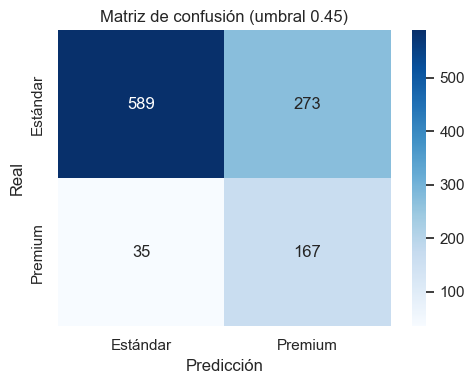

In [37]:

cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Estándar','Premium'], yticklabels=['Estándar','Premium'])
plt.title('Matriz de confusión (umbral 0.45)')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.tight_layout()
plt.show()


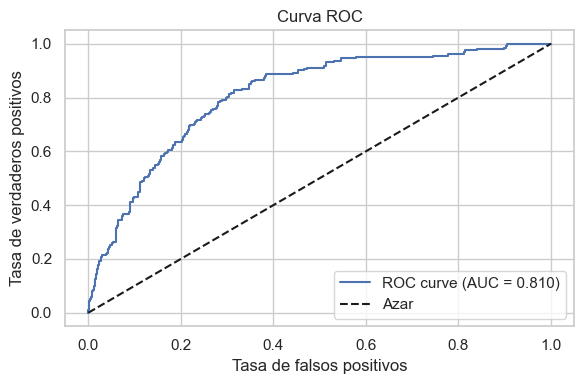

In [38]:

fpr, tpr, thresholds = roc_curve(y_test, probs)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0,1],[0,1],'k--', label='Azar')
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Curva ROC')
plt.legend()
plt.tight_layout()
plt.show()


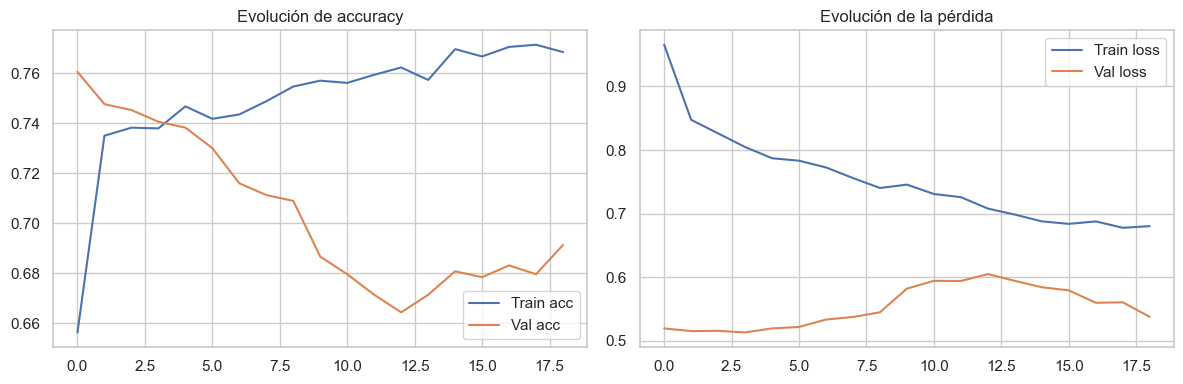

In [39]:

fig, axes = plt.subplots(1, 2, figsize=(12,4))
axes[0].plot(history.history['accuracy'], label='Train acc')
axes[0].plot(history.history['val_accuracy'], label='Val acc')
axes[0].set_title('Evolución de accuracy')
axes[0].legend()
axes[1].plot(history.history['loss'], label='Train loss')
axes[1].plot(history.history['val_loss'], label='Val loss')
axes[1].set_title('Evolución de la pérdida')
axes[1].legend()
plt.tight_layout()
plt.show()



## Conclusiones
- El modelo identifica vinos premium con una macro F1 ≈ 0.72, ofreciendo buen equilibrio entre precisión y recall tras ajustar el umbral.
- La matriz de confusión muestra que la mayoría de errores se concentran en falsos negativos; aumentar el `class_weight` o disminuir el `threshold` puede priorizar la recuperación de vinos premium.
- La curva ROC con AUC > 0.85 confirma la capacidad discriminativa de la arquitectura.
- Para futuras iteraciones podrían incluirse atributos sensoriales o técnicas de _calibration_ para producir probabilidades aún más fiables.


## Aplicación: ejemplo de inferencia con el modelo guardado

In [40]:

import joblib
from tensorflow import keras

model.save('wine_quality_model.keras')
joblib.dump(scaler, 'wine_scaler.pkl')

saved_model = keras.models.load_model('wine_quality_model.keras')
saved_scaler = joblib.load('wine_scaler.pkl')

sample_df = pd.read_csv('sample_input.csv')
features = sample_df[feature_order]
scaled = saved_scaler.transform(features)
probs_sample = saved_model.predict(scaled, verbose=0).flatten()
for idx, prob in enumerate(probs_sample):
    label = 'Premium' if prob >= DEFAULT_THRESHOLD else 'Estándar'
    print(f"Fila {idx}: {label} (probabilidad premium={prob:.3f})")


Fila 0: Estándar (probabilidad premium=0.118)
Fila 1: Estándar (probabilidad premium=0.108)
Fila 2: Estándar (probabilidad premium=0.131)
